# Libraries

In [14]:
#libraries 
import pandas as pd 
import requests 
from bs4 import BeautifulSoup 
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
%matplotlib inline 
!pip install lyricsgenius
from lyricsgenius import OAuth2, Genius
import matplotlib.pyplot as plt 
import seaborn as sns


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Webscraping 

In [2]:
#url to scrape
wikiurl='https://en.wikipedia.org/wiki/List_of_Eurovision_Song_Contest_entries_(2004%E2%80%93present)'
response=requests.get(wikiurl)
print(response.status_code) # ok 



200


In [3]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
table_class="wikitable plainrowheaders"

my_tables=soup.find_all('table',{'class':"wikitable"})



# Data Wrangling

In [6]:
# join the tables into a single dataframe

#for table in my_tables:
df=pd.read_html(str(my_tables))


df0=pd.DataFrame(df[0])
df1=pd.DataFrame(df[1])
df2=pd.DataFrame(df[2])
df3=pd.DataFrame(df[3])
df4=pd.DataFrame(df[4])
df5=pd.DataFrame(df[5])
df6=pd.DataFrame(df[6])
df7=pd.DataFrame(df[7])
df8=pd.DataFrame(df[8])
df9=pd.DataFrame(df[9])
df10=pd.DataFrame(df[10])
df11=pd.DataFrame(df[11])
df12=pd.DataFrame(df[12])
df13=pd.DataFrame(df[13])
df14=pd.DataFrame(df[14])
df15=pd.DataFrame(df[15])
df16=pd.DataFrame(df[16])


df= pd.concat([df0,df1,df2, df3, df4, df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16], axis=0)

df.set_index('#')




,R/O SF,R/O F,Country,#.1,Artist,Song,Language,Songwriter(s),Placing
#,,,,,,,,,
918,1,NaN,Finland,38,Jari Sillanpää,"""Takes 2 to Tango""",English,Mika ToivanenJari Sillanpää,DNQ (14)
919,2,NaN,Belarus,1,Aleksandra and Konstantin,"""My Galileo""",English,Aleksandra KirsanovaKonstantin DrapezoAleksey ...,DNQ (19)
920,3,NaN,Switzerland,45,Piero Esteriore and the MusicStars,"""Celebrate!""",English,Greg Manning,DNQ (22 ◁)
921,4,NaN,Latvia,5,Fomins and Kleins,"""Dziesma par laimi""",Latvian,Guntars RačsTomass Kleins,DNQ (17)
922,5,NaN,Israel,27,David D'Or,"""Leha'amin"" (להאמין)","Hebrew, English",David D'OrOfer MeiriEhud Manor,DNQ (11)
...,...,...,...,...,...,...,...,...,...
1599,NaN,13.0,Spain,60,Blas Cantó,"""Voy a quedarme""",Spanish,Blas CantóLeroy SanchezDangelo OrtegaDan Hammond,24
1600,NaN,15.0,Germany,64,Jendrik,"""I Don't Feel Hate""",English[c],Jendrik SigwartChristoph Oswald,25
1601,NaN,20.0,France,63,Barbara Pravi,"""Voilà""",French,"Barbara PraviAntoine ""Igit"" BarrauLili Poe",2


In [7]:
# clean the placing ranks 
df['Placing_clean']=df['Placing'].str.split('(').str[0]  #remove (
df['Placing_clean']=df['Placing_clean'].str.split('◁').str[0]  #remove ◁
df['Placing_clean']=df['Placing'].str.split(' ').str[0] # strip " "
df=df.drop(['R/O SF', 'R/O F', '#.1', 'Placing'], axis=1) # drop unwanted columns, semifinal information


In [9]:
#clean song names

def clean_text(text):
    # remove backslash-apostrophe  as song names are in quotes
    text = re.sub("\'", "", text) 

    text = re.sub("[^a-zA-Z]"," ",text) #remove some non-English text strings
    # remove whitespaces 
    text = ' '.join(text.split()) 
  
    return text

df['Clean_Song'] = df['Song'].apply(lambda x: clean_text(x))




In [10]:
# clean language names

# languages
df['Language_clean']=df['Language'].str.split('[').str[0] # some entries have [] after language -artifact from wiki tooltip

df['Language_clean'].value_counts().head(50)

English                                                451
French                                                  16
Spanish                                                 13
Serbian                                                 12
Italian                                                 12
Portuguese                                              11
Slovene                                                  7
Albanian                                                 7
Montenegrin                                              7
Croatian                                                 7
Greek                                                    6
Hebrew, English                                          5
French, English                                          5
Bosnian                                                  5
Hungarian                                                5
Macedonian                                               4
Bulgarian                                               

In [11]:
# drop all non English as only doing English NLP 



df_English= df[df['Language_clean'] == 'English']


df_English=df_English.drop(['Song', 'Language', 'Language_clean', '#'], axis=1)


df_English=df_English[['Clean_Song', 'Artist', 'Country', 'Placing_clean', 'Songwriter(s)']]

df_English.info()



df_English['UI']=df_English['Clean_Song']+ ' ' + df_English['Artist']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 451 entries, 0 to 35
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Clean_Song     451 non-null    object
 1   Artist         451 non-null    object
 2   Country        451 non-null    object
 3   Placing_clean  451 non-null    object
 4   Songwriter(s)  451 non-null    object
dtypes: object(5)
memory usage: 21.1+ KB


# Exploratory Data Analysis 

In [12]:
# make df of artists and how often they won

df_English.nunique()

df_English['Artist'].value_counts()

artist_counts=df_English['Artist'].value_counts().to_frame()


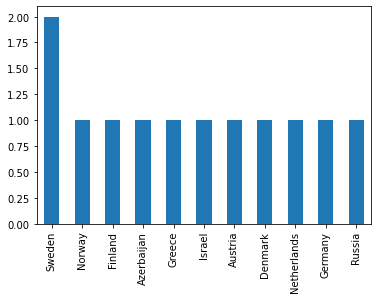

In [15]:
# look at country distribution of  winners

win_df = df_English.loc[df_English['Placing_clean'] =='1']
fig, ax = plt.subplots()
win_df['Country'].value_counts().plot(ax=ax, kind='bar')


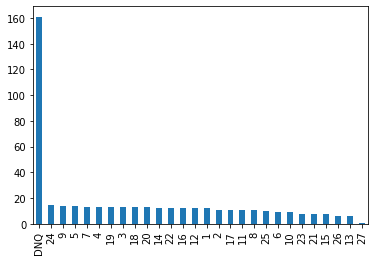

In [16]:
# look at placing distribuiton
fig, ax = plt.subplots()
df_English['Placing_clean'].value_counts().plot(ax=ax, kind='bar')

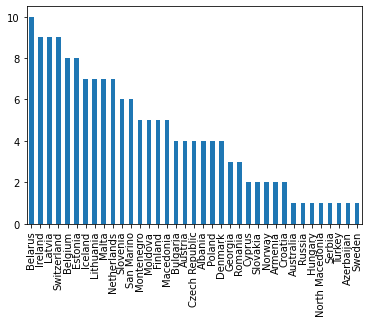

In [17]:

# look at DNQ Distribuiton

DNQ_df = df_English.loc[df_English['Placing_clean'] =='DNQ']
fig, ax = plt.subplots()
DNQ_df['Country'].value_counts().plot(ax=ax, kind='bar')


# Connect to Genius API

In [18]:
# API parameters 
client_id= 'Z6TV3xLBR5kNt9fil9CqSljs7fCUDB_QMmVgFxjoFtM-zn20FBEaC5pB5vSItK22NqtxU_utKMQjzFH8VrLCwQ'
token='OH2W0UZMIITH_n50lrn5D3EiNWGeZOspU9AYssgMv2dYVBOmSwRiNAneJz0LPfXV'

genius = Genius('OH2W0UZMIITH_n50lrn5D3EiNWGeZOspU9AYssgMv2dYVBOmSwRiNAneJz0LPfXV',
                skip_non_songs=True, excluded_terms=["(Remix)", "(Live)"], remove_section_headers=True, timeout=20)


In [19]:
# Create unique identifier of song name and song artist to input to API
song_artist=df_English['Clean_Song']+ ' ' + df_English['Artist']  #concat for API input 

song_artist=song_artist.tolist() # make as list



In [20]:
# get song lyrics for eurovision songs from API 
def get_lyrics(tune):
  songs = genius.search_songs(tune, per_page=1)

  try:
    UI=tune
    for tune in songs['hits']:
        url = tune['result']['url']
        artist_name= tune['result']['artist_names']
        title= tune['result']['title']
          #print(url)
        print(title)
        print('getting info for song: ',title)
        song_lyrics = genius.lyrics(song_url=url)
        #print(song_lyrics)
    return {'artist':artist_name, 'title':title,'lyrics':song_lyrics, 'UI':UI} 
  
  except NameError:
    UI=tune
    print('cant find')
    return {'artist':'', 'title':'','lyrics':'', 'UI':UI } 

  except ReadTimeoutError:
    UI=tune
    print('cant find')
    return {'artist':'', 'title':'','lyrics':'', 'UI':UI } 

info = []
for tune in song_artist:
  info.append(get_lyrics(tune))


Takes 2 To Tango
getting info for song:  Takes 2 To Tango
My Galileo
getting info for song:  My Galileo
cant find
On Again... Off Again
getting info for song:  On Again... Off Again
Shake It
getting info for song:  Shake It
What Happened To Your Love
getting info for song:  What Happened To Your Love
The Image Of You
getting info for song:  The Image Of You
Stronger Every Minute
getting info for song:  Stronger Every Minute
Life
getting info for song:  Life
Stay Forever
getting info for song:  Stay Forever
You Are The Only One
getting info for song:  You Are The Only One
Shame On You
getting info for song:  Shame On You
In The Disco
getting info for song:  In The Disco
Without You
getting info for song:  Without You
High
getting info for song:  High
1 Life
getting info for song:  1 Life
Believe Me
getting info for song:  Believe Me
Heaven
getting info for song:  Heaven
If My World Stopped Turning
getting info for song:  If My World Stopped Turning
Hold On To Our Love
getting info for s

In [21]:
# convert data from api to dataframe 
lyric_df = pd.DataFrame(info)

lyric_df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  451 non-null    object
 1   title   451 non-null    object
 2   lyrics  450 non-null    object
 3   UI      451 non-null    object
dtypes: object(4)
memory usage: 14.2+ KB


In [22]:
# join lyrics dataframe to dataframe of Eurovision entries 
corpus = pd.merge(df_English, lyric_df, on = 'UI')

corpus=corpus.drop(['Clean_Song', 'Artist', 'Songwriter(s)', 'UI'], axis=1)


corpus.head(30)

,Country,Placing_clean,artist,title,lyrics
0,Finland,DNQ,Jari Sillanpää,Takes 2 To Tango,"Time to leave, time to feel\nHarp and horn, mu..."
1,Belarus,DNQ,Aleksandra & Konstantin,My Galileo,"I'm no stay-at-home, and heady\nIs my quest an..."
2,Switzerland,DNQ,,,
3,Malta,12,Julie & Ludwig,On Again... Off Again,"Look at me, I need some attention\nI'm a girl ..."
4,Greece,3,Sakis Rouvas,Shake It,"Every time you wanna play\nTurn me on, all the..."
5,Lithuania,DNQ,Linas & Simona,What Happened To Your Love,What's happened to your love?\nWhat's happened...
6,Albania,7,Anjeza Shahini,The Image Of You,How strange the feeling in your soul\nWhen lov...
7,Cyprus,5,Lisa Andreas,Stronger Every Minute,No matter where I am\nI'm always thinking of y...
8,Macedonia,14,Toše Proeski,Life,I saw my ID and it wasn't me\nIt was someone e...
9,Slovenia,DNQ,Platin,Stay Forever,"Ooh... hey yeah yeah\nCome on, let's fly away,..."


# Lyrics Data Cleaning

In [23]:
# remove blank lyrics
# drop songs where lyrics is blank (couldn't be found by API)
corpus= corpus.replace('',np.nan)
corpus = corpus[corpus['lyrics'].notna()]


In [25]:
# remove stop words
stop_words = set(stopwords.words('english')) # use NLTK stopwords


# function to remove stopwords
def remove_stopwords(text):
    no_stop_lyrics = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stop_lyrics)

corpus['lyrics_nostop'] = corpus['lyrics'].apply(lambda x: remove_stopwords(x))



In [26]:
# clean lyrics 
def clean_lyrics(text):

  # remove \n for new line in song
  text = re.sub("\n'", "", text)  
   # remove backslash-apostrophe 
  text = re.sub("\'", "", text) 
  # remove everything except letters 
  text = re.sub("[^a-zA-Z]"," ",text) 
  # remove whitespaces 
  text = ' '.join(text.split()) 

  return text

corpus['clean_lyrics_nostop'] = corpus['lyrics_nostop'].apply(lambda x: clean_text(x))

corpus['clean_lyrics_nostop'] = corpus['clean_lyrics_nostop'].str.lower()


corpus.head()




,Country,Placing_clean,artist,title,lyrics,lyrics_nostop,clean_lyrics_nostop
0,Finland,DNQ,Jari Sillanpää,Takes 2 To Tango,"Time to leave, time to feel\nHarp and horn, mu...","Time leave, time feel Harp horn, music's born ...",time leave time feel harp horn musics born two...
1,Belarus,DNQ,Aleksandra & Konstantin,My Galileo,"I'm no stay-at-home, and heady\nIs my quest an...","I'm stay-at-home, heady Is quest venture mode ...",im stay at home heady is quest venture mode an...
3,Malta,12,Julie & Ludwig,On Again... Off Again,"Look at me, I need some attention\nI'm a girl ...","Look me, I need attention I'm girl serious int...",look me i need attention im girl serious inten...
4,Greece,3,Sakis Rouvas,Shake It,"Every time you wanna play\nTurn me on, all the...","Every time wanna play Turn on, way Come take r...",every time wanna play turn on way come take ri...
5,Lithuania,DNQ,Linas & Simona,What Happened To Your Love,What's happened to your love?\nWhat's happened...,What's happened love? What's happened love? We...,whats happened love whats happened love weve t...


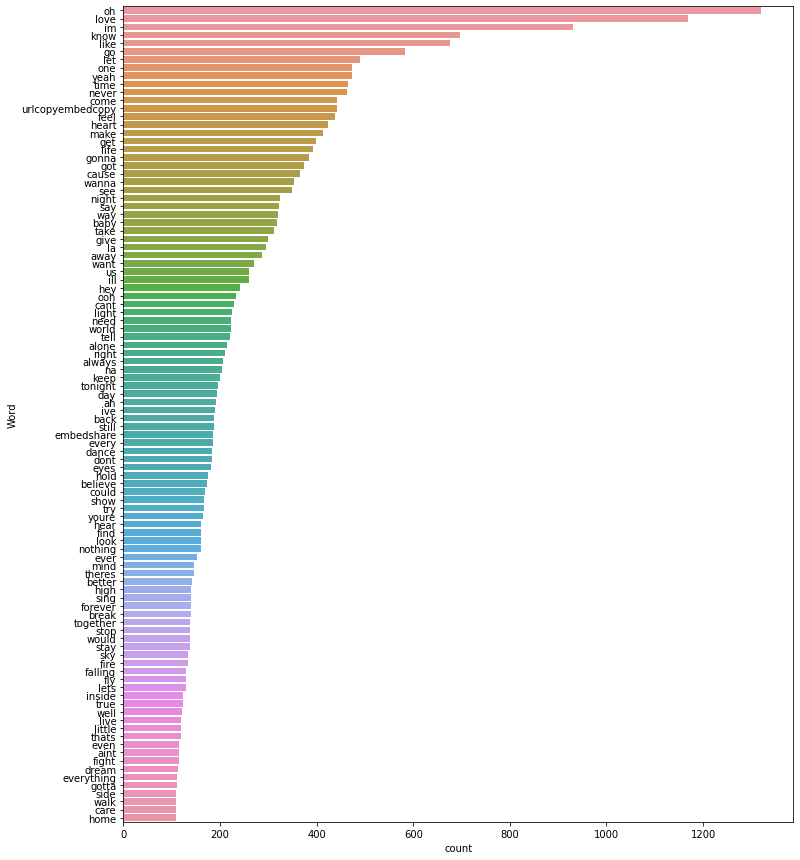

In [28]:
# Visualise corpus- freq of top 100 most common words 


def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
 

  d = words_df.nlargest(columns="count", n = terms)   
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  

freq_words(corpus['clean_lyrics_nostop'], 100)


In [30]:
# want to add more stopwords that are lyrics 
NLTK_stop_words_list=stopwords.words('english')
custom_stop_word_list=['oh', 'im', 'ah', 'ive', 'ha', 'ill', 'ooh', 'urlcopyembedcopy', 'embedshare', 'mhm', 'ooh', 'u', 'la','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa']
                    
final_stopword_list = custom_stop_word_list + NLTK_stop_words_list


# remove new stop words

def remove_stopwords(text):
    no_stop_lyrics = [w for w in text.split() if not w in final_stopword_list]
    return ' '.join(no_stop_lyrics)

corpus['clean_lyrics_nostop'] = corpus['clean_lyrics_nostop'].apply(lambda x: remove_stopwords(x))


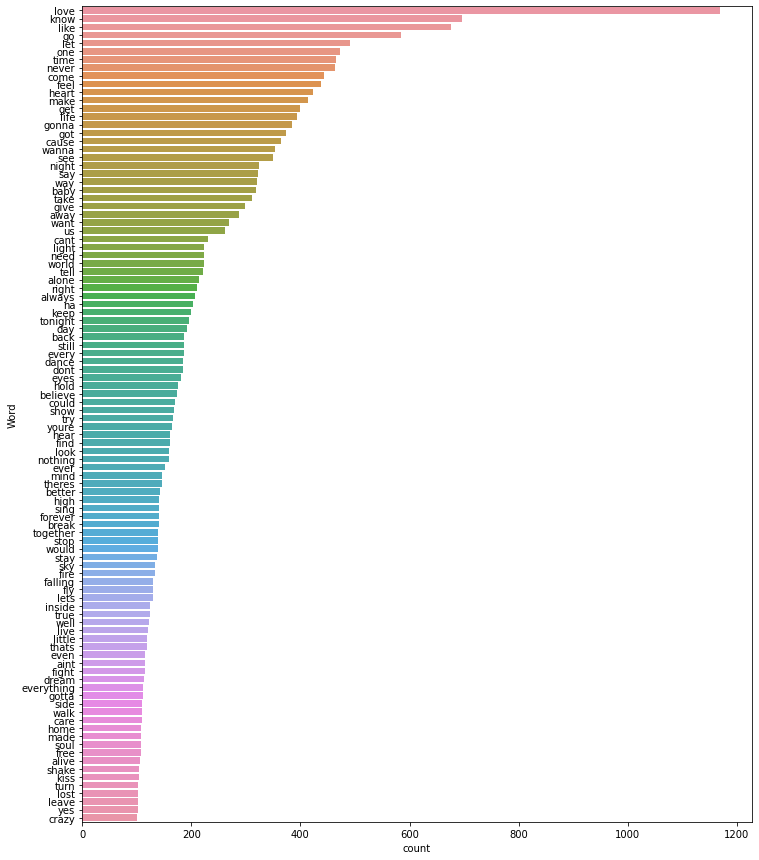

In [31]:
# visualise top 100 most frequent words again after removing lyric stopwords
freq_words(corpus['clean_lyrics_nostop'], 100)

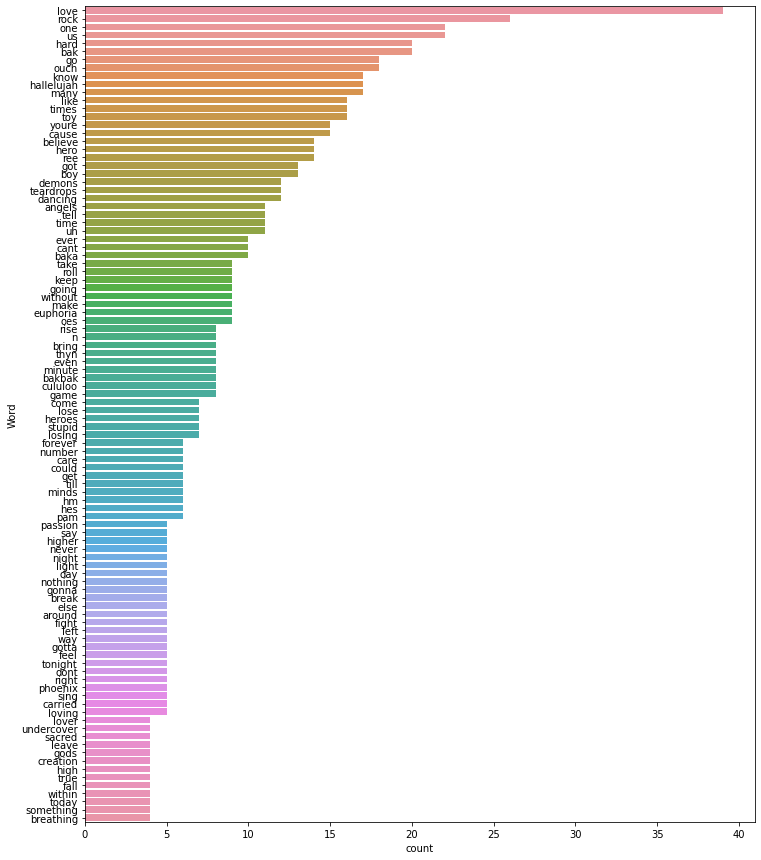

In [32]:
# look at top 100 words winners

corpus['Placing_clean']=corpus['Placing_clean'].str.split(' ').str[0]

winners = corpus.loc[corpus['Placing_clean'] =='1']

freq_words(winners['clean_lyrics_nostop'], 100)

In [33]:
# Save the data to .csv
import os
os.makedirs('corpus', exist_ok=True)
corpus.to_csv('cleaned_corpus.csv', index=True)

